In [14]:
import csv
from datetime import timedelta
import gurobipy as gp 
from gurobipy import GRB
import networkx as nx
import random
import matplotlib.pyplot as plt
import inspect

In [15]:
def hhmm2mins(hhmm):
    h, m = map(int, hhmm.split(':'))
    return h*60 + m

def mins2hhmm(mins):
    h = mins // 60
    m = mins % 60
    return f"{h:02}:{m:02}"

class Service:
    def __init__(self, attrs):
        self.serv_num = int(attrs[0])
        self.train_num = attrs[1]
        self.start_stn = attrs[2]
        self.start_time = hhmm2mins(attrs[3])
        self.end_stn = attrs[4]
        self.end_time = hhmm2mins(attrs[5])
        self.direction = attrs[6]
        self.serv_dur = int(attrs[7])
        self.jurisdiction = attrs[8]
        self.stepback_train_num = attrs[9]
        self.serv_added = False
        self.break_dur = 0
        self.trip_dur = 0

# Reading file and creating a list of services
def fetch_data(filename):
    services = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            services.append(Service(row))
    return services

# To check if two services can be connected
def node_legal(service1, service2):
    if service1.stepback_train_num == "No Stepback":
        if service2.train_num == service1.train_num:
            if service1.end_stn == service2.start_stn and 0 <= (service2.start_time - service1.end_time) <= 15:
                return True
        else:
            if (service1.end_stn[:4] == service2.start_stn[:4]) and (service2.start_time >= service1.end_time + 30) and (service2.start_time <= service1.end_time + 150):
                return True
        
    else:
        if service2.train_num == service1.stepback_train_num:
            if (service1.end_stn == service2.start_stn) and (service1.end_time == service2.start_time):
                return True
        else:
            if (service1.end_stn[:4] == service2.start_stn[:4]) and (service2.start_time >= service1.end_time + 30 ) and (service2.start_time <= service1.end_time + 150):
                return True
    return False

# For creating the duty graph
def create_duty_graph(services):
    G = nx.DiGraph()

    for service1 in services:
        G.add_node(service1.serv_num)
        print(service1.serv_num)

    for i, service1 in enumerate(services):
        for j, service2 in enumerate(services):
            if i != j:
                if node_legal(service1, service2):
                    G.add_edge(service1.serv_num, service2.serv_num, weight=service1.serv_dur)
    return G

# Also helper function for generating duties
def can_append(duty, service):
    last_service = duty[-1]
    
    start_end_stn_tf = last_service.end_stn == service.start_stn

    start_end_time_tf = 5 <= (service.start_time - last_service.end_time) <= 15
    start_end_stn_tf_after_break = last_service.end_stn[:4] == service.start_stn[:4]
    start_end_time_within = 50 <= (service.start_time - last_service.end_time) <= 150

    if last_service.stepback_train_num == "No StepBack":
        start_end_rake_tf = last_service.train_num == service.train_num
    else:
        start_end_rake_tf = last_service.stepback_train_num == service.train_num
    
    # Check for valid conditions and time limits
    if start_end_rake_tf and start_end_stn_tf and start_end_time_tf:
        time_dur = service.end_time - duty[0].start_time
        cont_time_dur = sum([serv.serv_dur for serv in duty])
        if cont_time_dur <= 180 and time_dur <= 445:
            return True
    elif start_end_time_within and start_end_stn_tf_after_break:
        time_dur = service.end_time - duty[0].start_time
        if time_dur <= 445:
            return True
    return False

In [16]:
def generate_initial_feasible_duties_random_from_services(services, num_duties=50):
    """
    Generate a list of feasible duties from the list of services.

    Args:
        services: list of services
        num_duties: number of duties to generate

    Returns:
        random list of duties: each duty is a list of service numbers
    """
    feasible_duties = []

    for service1 in services:
        duty = [service1]
        for service2 in services:
            if service1.serv_num != service2.serv_num:
                if can_append(duty, service2):
                    duty.append(service2)
        feasible_duties.append(duty)
    
    fd2 = []
    for duty in feasible_duties:
        fd2.append([serv.serv_num for serv in duty])
    print(len(fd2))

    fd3 = random.sample(fd2, num_duties)

    return fd3

In [17]:
from gurobipy import Model, GRB, quicksum

def solve_master_lp(services, duties, duty_costs):
    """
    Solves the master LP for one iteration of column generation.

    Args:
        services (list): List of all services to be covered.
        duties (list): List of current duties (each duty contains 'services' it covers and its 'cost').
        graph (networkx.DiGraph, optional): NetworkX graph if needed for the next step.

    Returns:
        dict: {
            "dual_values": Dual values for each service (to use in the pricing problem),
            "primal_solution": Solution for the current duties,
            "objective_value": Optimal value of the master LP,
            "RMP_model": Gurobi model object for potential debugging,
        }
    """
    # Create Gurobi model
    model = Model("MasterLP")
    model.setParam('OutputFlag', 0)

    big_penalty = 1e6
    
    # Add variables for each duty (decision variables)
    duty_vars = {}
    for idx, cost in enumerate(duty_costs):
        duty_vars[idx] = model.addVar(
            vtype=GRB.CONTINUOUS, 
            lb=0, 
            obj=cost, 
            name=f"duty_{idx}"
        )

    artificial_vars = {}
    for service in services:
        artificial_vars[service] = model.addVar(
            vtype=GRB.CONTINUOUS, 
            lb=0, 
            obj=big_penalty,  # High penalty
            name=f"artificial_{service.serv_num}"
        )
    
    # Add constraints: Each service must be covered exactly once
    constraints = {}
    for service in services:
        constraints[service] = model.addConstr(
            quicksum(duty_vars[idx] for idx, duty in enumerate(duties) if service.serv_num in duty) + artificial_vars[service] == 1,
            name=f"cover_{service}"
        )

    
    # Set objective: Minimize total cost
    model.setObjective(
        quicksum(duty_vars[idx] * cost for idx, cost in enumerate(duty_costs)) +
        quicksum(artificial_vars[service] * big_penalty for service in services),
        GRB.MINIMIZE
    )
    
    # Optimize the master LP
    model.optimize()
    
    # Retrieve dual values from constraints
    dual_values = {service.serv_num: constraints[service].Pi for service in services}
    
    # Retrieve the primal solution for the duty variables
    primal_solution = {f"duty_{idx}": var.X for idx, var in duty_vars.items()}
    
    # Return results
    return {
        "dual_values": dual_values,
        "primal_solution": primal_solution,
        "objective_value": model.ObjVal,
        "RMP_model": model
    }

def make_duty_costs(graph, duties):            # Some services are end services so they dont have edges, take that into account later on
    duty_costs = []
    for duty in duties:
        cost = 0
        for service in duty:
            edges_from_service = graph.edges(service, data=True)
            for _, _, edge_data in edges_from_service:
                cost += edge_data['weight']
                break
        duty_costs.append(cost)
    return duty_costs

In [18]:
from gurobipy import Model, GRB, quicksum

def solve_master_lp_2(services, duties, duty_costs):
    """
    Solves the master LP for one iteration of column generation.

    Args:
        services (list): List of all services to be covered.
        duties (list): List of current duties (each duty contains 'services' it covers and its 'cost').
        graph (networkx.DiGraph, optional): NetworkX graph if needed for the next step.

    Returns:
        dict: {
            "dual_values": Dual values for each service (to use in the pricing problem),
            "primal_solution": Solution for the current duties,
            "objective_value": Optimal value of the master LP,
            "RMP_model": Gurobi model object for potential debugging,
        }
    """
    # Create Gurobi model
    model = Model("MasterLP")
    model.setParam('OutputFlag', 0)

    
    # Add variables for each duty (decision variables)
    duty_vars = {}
    for idx, cost in enumerate(duty_costs):
        duty_vars[idx] = model.addVar(
            vtype=GRB.CONTINUOUS, 
            lb=0, 
            obj=cost, 
            name=f"duty_{idx}"
        )

    
    # Add constraints: Each service must be covered exactly once
    constraints = {}
    for service in services:
        tt = 0
        for idx, duty in enumerate(duties):
            if service.serv_num in duty:
                tt += duty_vars[idx]
        constraints[service] = model.addConstr(tt == 1, name=f"cover_{service.serv_num}")

    
    # Set objective: Minimize total cost
    model.setObjective(
        quicksum(duty_vars[idx] * cost for idx, cost in enumerate(duty_costs)),
        GRB.MINIMIZE
    )
    
    # Optimize the master LP
    model.optimize()

    # Loop through the `constraints` dictionary to inspect each constraint
    # for service, constr in constraints.items():
    #     # Get the left-hand side (LHS) of the constraint
    #     lhs = model.getRow(constr)

    #     # Get the right-hand side (RHS) of the constraint
    #     rhs = constr.RHS

    #     # Reconstruct the LHS equation as a string
    #     lhs_terms = []
    #     for i in range(lhs.size()):
    #         coeff = lhs.getCoeff(i)  # Coefficient of the variable
    #         var_name = lhs.getVar(i).VarName  # Variable name
    #         lhs_terms.append(f"{coeff} * {var_name}")

    #     # Join terms to form the LHS equation
    #     lhs_str = " + ".join(lhs_terms)

    #     # Get the sense of the constraint ('=', '<=', '>=')
    #     sense = constr.Sense
    #     sense_str = {"=": "==", "<": "<=", ">": ">="}[sense]

    #     # Print the full constraint equation
    #     print(f"Constraint for Service {service.serv_num}: {lhs_str} {sense_str} {rhs}")
    
    # Retrieve dual values from constraints
    dual_values = {service.serv_num: constraints[service].Pi for service in services}
    
    # Retrieve the primal solution for the duty variables
    primal_solution = {f"duty_{idx}": var.X for idx, var in duty_vars.items()}
    
    # Return results
    return {
        "dual_values": dual_values,
        "primal_solution": primal_solution,
        "objective_value": model.ObjVal,
        "RMP_model": model
    }

In [19]:
def solve_pricing_problem(graph, dual_values, source, sink):
    """
    Solves the pricing problem to generate new duties with negative reduced cost.

    Args:
        graph (networkx.DiGraph): Directed graph with edge weights representing service durations
        dual_values (dict): Dual values for each service number (node)
        source (int): Starting service number for the duty
        sink (int): Ending service number for the duty

    Returns:
        list: List of new duties with negative reduced cost. Each duty is a dictionary:
            {"path": [...], "reduced_cost": float, "cost": float}
    """
    # Create a copy of the graph to adjust weights
    modified_graph = graph.copy()
    
    # Adjust edge weights based on dual values
    for u, v, data in modified_graph.edges(data=True):
        if u in dual_values:
            data['weight'] -= dual_values[u]  # Modify weight using dual value of the source node
    
    # Check for negative weight cycles
    # try:
    #     cycle = nx.find_negative_cycle(modified_graph, source)
    #     raise ValueError(f"Graph contains a negative cycle: {cycle}")
    # except nx.NetworkXNoCycle:
    #     pass  # No negative cycles, safe to proceed

    # Find the shortest path from source to sink (Bellman Ford used)
    try:
        shortest_path = nx.bellman_ford_path(modified_graph, source=source, target=sink, weight='weight')
        
        # Calculate original path cost
        for u, v in zip(shortest_path[:-1], shortest_path[1:]):
            path_cost = sum(graph[u][v]['weight'])    
        
        # Calculate reduced cost
        reduced_cost = path_cost - sum(dual_values.get(node, 0) for node in shortest_path)
        
        # Check if reduced cost is negative
        if reduced_cost < 0:
            return {
                "path": shortest_path,
                "reduced_cost": reduced_cost,
                "cost": path_cost
            }
        else:
            return []  # No duties with negative reduced cost
    except nx.NetworkXNoPath:
        return []  # No feasible path found


In [20]:
def add_source_and_sink(graph, services):
    # Add source node
    graph.add_node("source")
    for service in services:
        if can_start_duty(service):
            graph.add_edge("source", service.serv_num, weight=0)

    # Add sink node
    graph.add_node("sink")
    for service in services:
        if can_end_duty(service):
            graph.add_edge(service.serv_num, "sink", weight=0)

    return graph

# Helper functions to determine if a service can start or end a duty
def can_start_duty(service):
    # Example: Services that can start duties
    return service.jurisdiction == "inducting" and service.start_time <= 450

def can_end_duty(service):
    # Example: Services that can end duties
    return service.end_time <= 1350

In [21]:
def column_generation(services, initial_duties, graph, max_iter = 50, prune_every=5):
    duties = initial_duties
    objective_values = []
    # duty_costs = make_duty_costs(graph, duties)
    iter = 0

    try:
        while iter < max_iter:
            print(f"Iteration {iter + 1}")

            duty_costs = make_duty_costs(graph, duties)
            # print(duty_costs)
            tt = solve_master_lp(services, duties, duty_costs)
            model, dual_values, obj_value, primal = tt["RMP_model"], tt["dual_values"], tt["objective_value"], tt['primal_solution']
            # print(primal)

            graph_with_source_sink = add_source_and_sink(graph.copy(), services)
            new_duties = solve_pricing_problem(graph_with_source_sink, dual_values, "source", "sink")
            print(f"Objective value: {obj_value}, {obj_value // 1e6}")
            objective_values.append(obj_value)

            if not new_duties:
                print("No new duties with negative reduced cost. Optimal solution found.")
                break
            
            if new_duties['path'][1:-1] in duties:
                print("Duty already exists. Skipping...")
                break
            duties.append(new_duties['path'][1:-1])
            
            if iter % prune_every == 0:
                duties = [duty for idx, duty in enumerate(duties) if model.getVarByName(f"duty_{idx}") is not None and model.getVarByName(f"duty_{idx}").X > 1e-4]  
            
            print(f"Number of duties after iteration {iter}: {len(duties)}")
            
            # for idx, duty in enumerate(duties):
            #     if model.getVarByName(f"duty_{idx}") is not None:
            #         print(model.getVarByName(f"duty_{idx}").X)


            iter += 1
            
    except Exception as e:
        print(e)
        print("Column generation failed.")
        return model, duties, objective_values
        
    return model, duties, objective_values

In [22]:
def draw_graph_with_edges(graph, n=50):
    # Create a directed subgraph containing only the first n edges
    subgraph = nx.DiGraph()
    
    # Add the first n edges and associated nodes to the subgraph
    edge_count = 0
    for u, v in graph.edges():
        if edge_count >= n:
            break
        subgraph.add_edge(u, v)
        edge_count += 1

    # Plotting the directed subgraph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(subgraph)  # Position nodes using the spring layout
    nx.draw_networkx_nodes(subgraph, pos, node_size=50, node_color='red')
    nx.draw_networkx_labels(subgraph, pos, font_size=15)
    nx.draw_networkx_edges(
        subgraph, pos, arrowstyle='->', arrowsize=20, edge_color='blue'
    )
    
    plt.title(f"First {n} Directed Edges of the Network")
    plt.show()

101
102
103
104
105
106
107
108
109
110


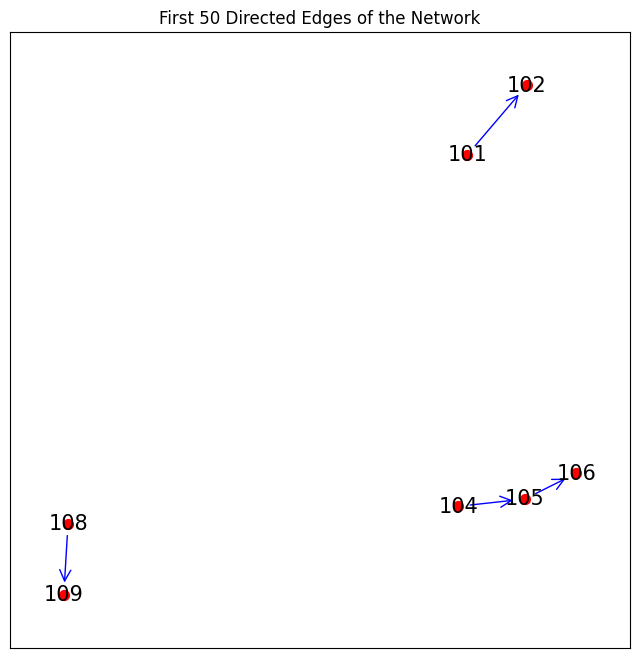

10
[[102], [110], [109], [107, 108], [104], [103], [105], [108], [106], [101, 102]]
Iteration 1
'int' object is not iterable
Column generation failed.
Final Objective Value: 130.0 0.0
number of duties made: 10
Final Duties:
[[102], [110], [109], [107, 108], [104], [103], [105], [108], [106], [101, 102]]


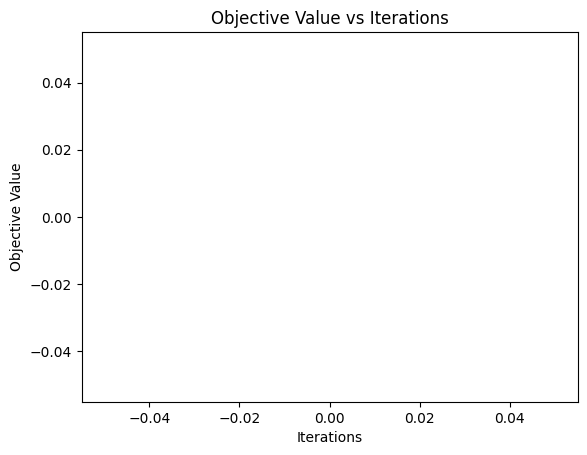

In [23]:
# services = fetch_data('StepBackServices.csv')
services = fetch_data('test.csv')
graph = create_duty_graph(services)
draw_graph_with_edges(graph, n = 50)
ini_duties = generate_initial_feasible_duties_random_from_services(services, num_duties=len(services))       # works fine
print(ini_duties)

pt = column_generation(services, ini_duties, graph, max_iter=200)
model, final_duties, objecive_values = pt

print("Final Objective Value:", model.objVal, model.objVal // 1e6)

print(f"number of duties made: {len(final_duties)}")

print("Final Duties:")
print(final_duties)

x = [i for i in range(len(objecive_values))]
plt.plot(x, objecive_values)
plt.xlabel("Iterations")
plt.ylabel("Objective Value")
plt.title("Objective Value vs Iterations")
plt.show()

In [24]:
tt = final_duties[-1]
for s1 in tt:
    for service in services:
        if service.serv_num == s1:
            print(service.serv_num, service.start_stn, service.end_stn, mins2hhmm(service.start_time), mins2hhmm(service.end_time))
            break


101 MKPD PVGW DN 06:00 06:35
102 PVGW DN KKDA DN 07:40 07:45


In [25]:
for var in model.getVars():
    # print(var.varName)
    if var.x > 0:
        print(var.varName, var.x)

duty_1 1.0
duty_2 1.0
duty_3 1.0
duty_4 1.0
duty_5 1.0
duty_6 1.0
duty_8 1.0
duty_9 1.0


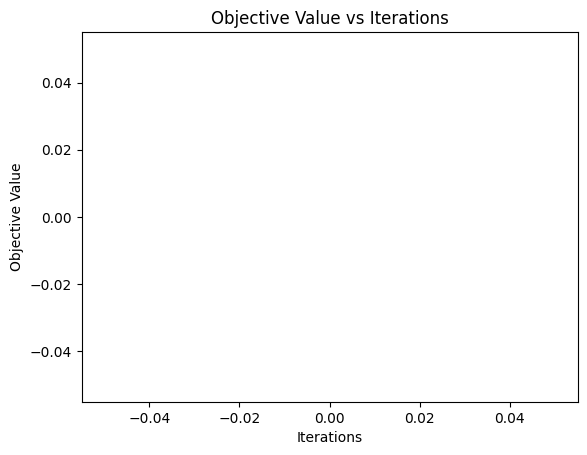

IndexError: list index out of range

In [26]:
# objecive_values = pt[2]
x = [i for i in range(len(objecive_values))]
plt.plot(x, objecive_values)
plt.xlabel("Iterations")
plt.ylabel("Objective Value")
plt.title("Objective Value vs Iterations")
plt.show()
print(objecive_values[0]//1e6, objecive_values[-1]//1e6)